# 循环神经网络的从零开始实现



In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
import math
import mindspore
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor
from d2l import mindspore as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

In [3]:
ops.one_hot(Tensor([0, 2], mindspore.int32), len(vocab), Tensor(1.0, mindspore.float32), Tensor(0.0, mindspore.float32))

Tensor(shape=[2, 28], dtype=Float32, value=
[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00 ...  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00 ...  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

小批量数据形状是（批量大小,时间步数）

In [4]:
X = d2l.reshape(d2l.arange(10), (2, 5))
ops.one_hot(Tensor(X.T, mindspore.int32), 28, Tensor(1.0, mindspore.float32), Tensor(0.0, mindspore.float32)).shape

(5, 2, 28)

初始化循环神经网络模型的模型参数

In [5]:
from mindspore import Parameter, ParameterTuple

def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return np.random.normal(scale=0.01, size=shape).astype(np.float32)
    
    # 隐藏层参数
    W_xh = Parameter(normal((num_inputs, num_hiddens)), name="W_xh")
    W_hh = Parameter(normal((num_hiddens, num_hiddens)), name="W_hh")
    b_h = Parameter(d2l.zeros(num_hiddens), name="b_h")
    # 输出层参数
    W_hq = Parameter(normal((num_hiddens, num_outputs)), name="W_hq")
    b_q = Parameter(d2l.zeros(num_outputs), name="b_q")
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return ParameterTuple(params)

一个`init_rnn_state`函数在初始化时返回隐状态

In [6]:
def init_rnn_state(batch_size, num_hiddens):
    return (d2l.zeros((batch_size, num_hiddens)), )

下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出

In [7]:
def rnn(inputs, state, params):
    # inputs的形状：（时间步数量，批量大小，词表大小）
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：（批量大小， 词表大小）
    for X in inputs:
        H = ops.tanh(ops.matmul(X, W_xh) + ops.matmul(H, W_hh) + b_h)
        Y = ops.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return d2l.concat(outputs, axis=0), (H, )

创建一个类来包装这些函数

In [8]:
class RNNModelScratch(nn.Cell): 
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens,
                 get_params, init_state, forward_fn):
        super().__init__()
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def construct(self, X, state):
        X = ops.one_hot(X.T, self.vocab_size, Tensor(1.0, mindspore.float32), Tensor(0.0, mindspore.float32))
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

检查输出是否具有正确的形状

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

((10, 28), 1, (2, 512))

首先定义预测函数来生成`prefix`之后的新字符

In [10]:
def predict_ch8(prefix, num_preds, net, vocab):  #@save
    """在`prefix`后面生成新字符"""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(Tensor([outputs[-1]], mindspore.int32), (1,1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1).asnumpy()))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab)

'time traveller w w w w w '

梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [11]:
def grad_clipping(grads, theta):  #@save
    """裁剪梯度。"""
    norm = ops.sqrt(sum(ops.sum((g ** 2)) for g in grads))
    if norm > theta:
        for g in grads:
            g[:] *= theta / norm

定义一个函数在一个迭代周期内训练模型

In [12]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和，词元数量
    # 定义前向函数
    def forward_fn(x, state, y):
        y_hat, state = net(x, state)
        l = loss(y_hat, y).mean()
        return l
    # 获取梯度函数
    grad_fn = mindspore.value_and_grad(forward_fn, None, weights=net.trainable_params())
    net.set_train()
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0])
        y = Y.T.reshape(-1)
        (l), grads = grad_fn(X, state, y)
        grad_clipping(grads, 1)
        if isinstance(updater, nn.Optimizer):
            updater(grads)
        else:
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l.asnumpy() * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现

In [13]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Cell):
        updater = nn.SGD(net.trainable_params(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.4, 13016.2 词元/秒
time travellerit s against reason said filbywin tranees be foree
travellerit s against reason said filbywin tranees be foree


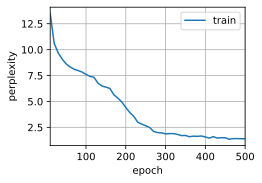

In [14]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs)

现在，我们训练循环神经网络模型

困惑度 180.2, 11243.1 词元/秒
time travellertttttttttttttttttttttttttttttttttttttttttttttttttt
travellertttttttttttttttttttttttttttttttttttttttttttttttttt


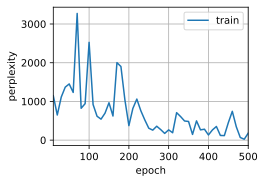

In [15]:
_train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=True)
_net = RNNModelScratch(len(vocab), num_hiddens, get_params, init_rnn_state, rnn)
train_ch8(_net, _train_iter, vocab, lr, num_epochs, use_random_iter=True)